## Bike Sharing Assignment

- Problem statement: Build a multiple linear regression model for the prediction of demand for shared bikes.
- Business goal: Understand the factors affecting the demand for these shared bikes in the American market. Find out:
    - Which variables are significant in predicting the demand for shared bikes.
    - How well those variables describe the bike demands

In [1]:
# Imports
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

### Data Understanding
- Load the data
- Understand the variable types from data and variable meaning from data dictionary
- Identify data quality issues, if any, to fix in data preparation step

In [2]:
df = pd.read_csv("day.csv", index_col=0)

In [3]:
df

dteday  season  yr  mnth  holiday  weekday  workingday  \
instant                                                               
1        01-01-2018       1   0     1        0        6           0   
2        02-01-2018       1   0     1        0        0           0   
3        03-01-2018       1   0     1        0        1           1   
4        04-01-2018       1   0     1        0        2           1   
5        05-01-2018       1   0     1        0        3           1   
...             ...     ...  ..   ...      ...      ...         ...   
726      27-12-2019       1   1    12        0        4           1   
727      28-12-2019       1   1    12        0        5           1   
728      29-12-2019       1   1    12        0        6           0   
729      30-12-2019       1   1    12        0        0           0   
730      31-12-2019       1   1    12        0        1           1   

         weathersit       temp     atemp      hum  windspeed  casual  \
instant                                                                
1                 2  14.110847  18.18125  80.5833  10.749882     331   
2                 2  14.902598  17.68695  69.6087  16.652113     131   
3                 1   8.050924   9.47025  43.7273  16.636703     120   
4                 1   8.200000  10.60610  59.0435  10.739832     108   
5                 1   9.305237  11.46350  43.6957  12.522300      82   
...             ...        ...       ...      ...        ...     ...   
726               2  10.420847  11.33210  65.2917  23.458911     247   
727               2  10.386653  12.75230  59.0000  10.416557     644   
728               2  10.386653  12.12000  75.2917   8.333661     159   
729               1  10.489153  11.58500  48.3333  23.500518     364   
730               2   8.849153  11.17435  57.7500  10.374682     439   

         registered   cnt  
instant                    
1               654   985  
2               670   801  
3              1229  1349  
4              1454  1562  
5              1518  1600  
...             ...   ...  
726            1867  2114  
727            2451  3095  
728            1182  1341  
729            1432  1796  
730            2290  2729  

[730 rows x 15 columns]

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 1 to 730
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   dteday      730 non-null    object 
 1   season      730 non-null    int64  
 2   yr          730 non-null    int64  
 3   mnth        730 non-null    int64  
 4   holiday     730 non-null    int64  
 5   weekday     730 non-null    int64  
 6   workingday  730 non-null    int64  
 7   weathersit  730 non-null    int64  
 8   temp        730 non-null    float64
 9   atemp       730 non-null    float64
 10  hum         730 non-null    float64
 11  windspeed   730 non-null    float64
 12  casual      730 non-null    int64  
 13  registered  730 non-null    int64  
 14  cnt         730 non-null    int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 91.2+ KB


- There are no nulls and all the columns except date time are in appropriate format
- The categorical variables season and weathersit are not ordinal, but have values which might imply order. So we will convert them to their string equivalent and then convert to dummy variables for use in modelling
- The variable weekday can be merged with workingday post EDA if it is not impactful. It also implies order from the values.

In [5]:
# Convert to datetime
df.dteday = pd.DatetimeIndex(df.dteday)

In [6]:
# Convert season to category string
season = {1:"spring", 2:"summer", 3:"fall", 4:"winter"}
df.season = df.season.apply(lambda x: season[x])

In [7]:
# Convert weathersit to category string
# weathersit : 
# 1: Clear, Few clouds, Partly cloudy, Partly cloudy
# 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
# 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
# 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

weathersit = {1: "clear", 2:"mist", 3:"light", 4:"heavy"}
df.weathersit = df.weathersit.apply(lambda x: weathersit[x])

### EDA
- Use pairplot to see the trends between numerical variables and the target variable
- Use boxplot to visualize categorical variables
- Plot heatmap to visualize correlation between variables

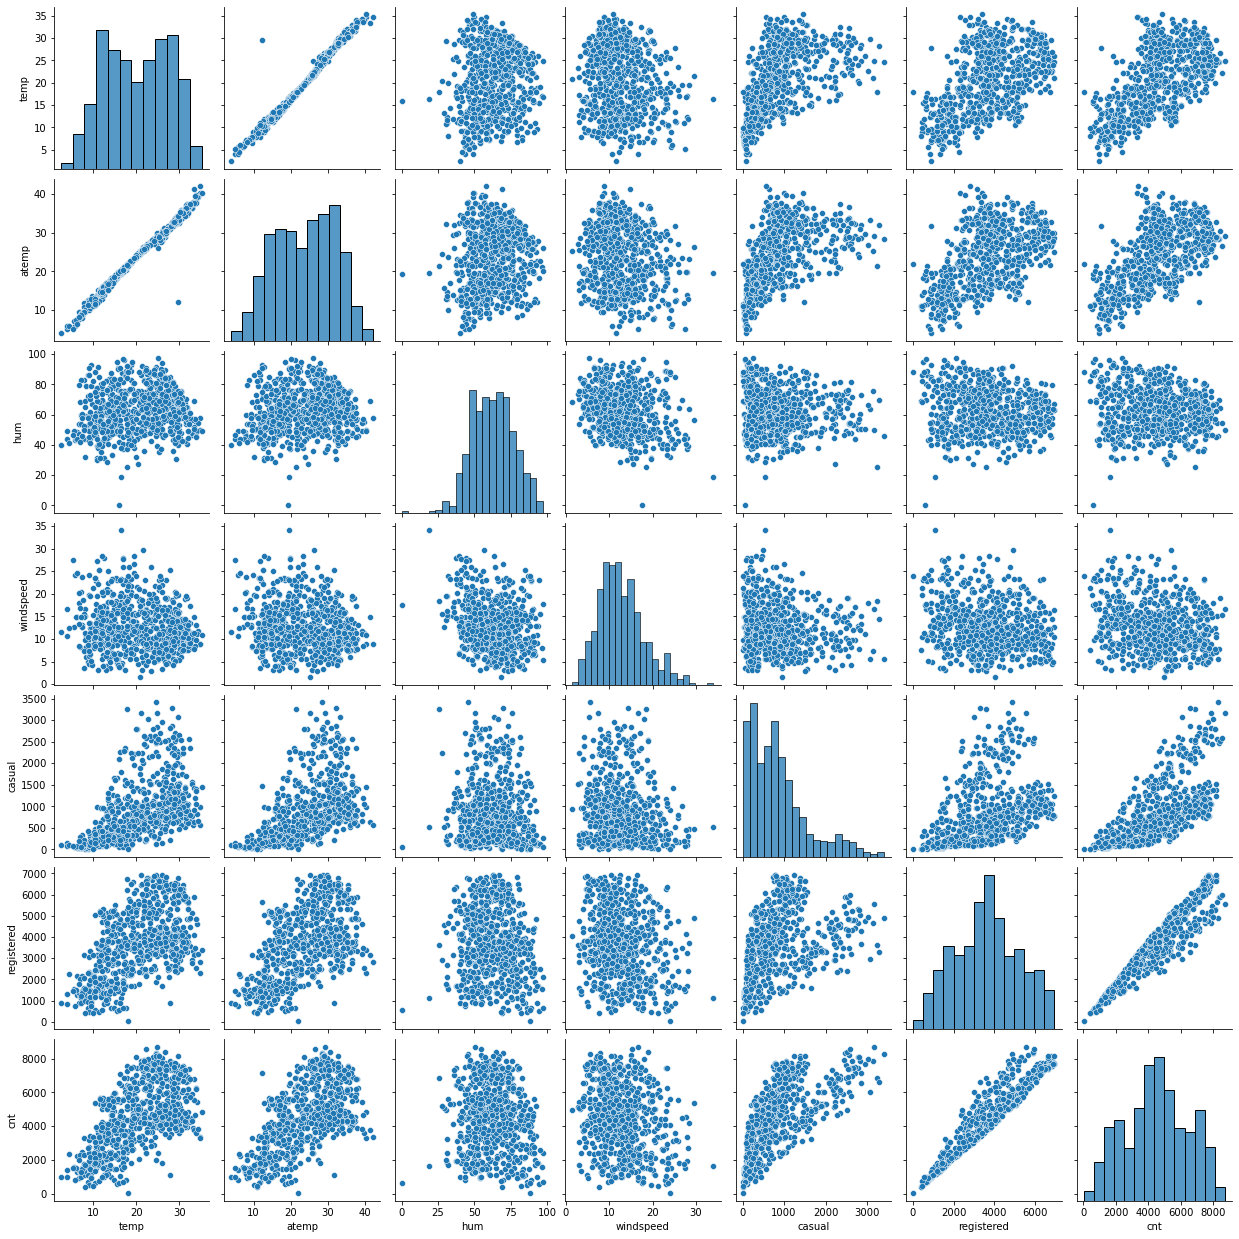

In [8]:
sns.pairplot(df[["temp", "atemp", "hum", "windspeed", "casual", "registered", "cnt"]])

<AxesSubplot:xlabel='season', ylabel='cnt'>

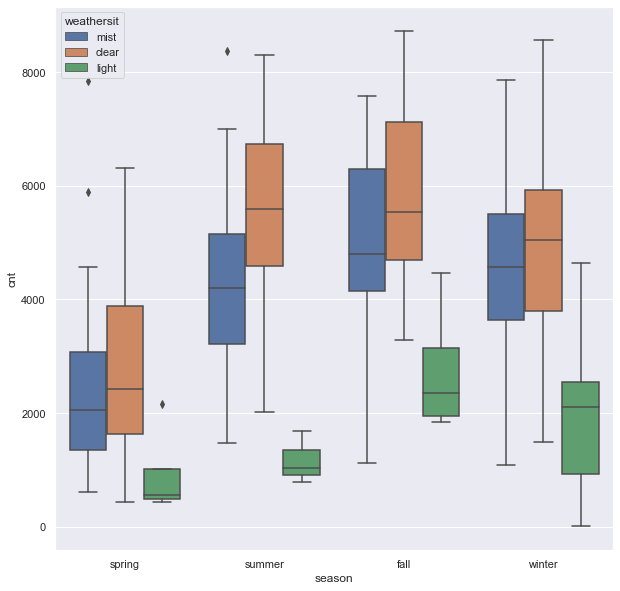

In [9]:
sns.set(rc={'figure.figsize':(10,10)})
sns.boxplot(x='season', y='cnt', hue='weathersit', data=df)

<AxesSubplot:xlabel='weathersit', ylabel='cnt'>

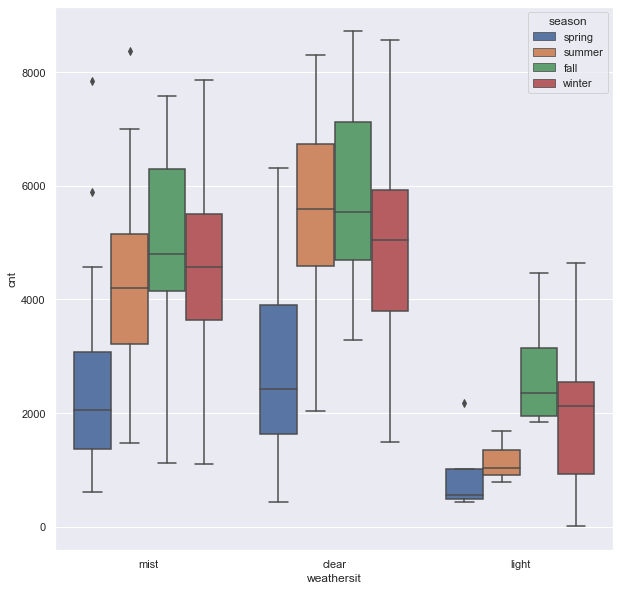

In [10]:
sns.set(rc={'figure.figsize':(10,10)})
sns.boxplot(x='weathersit', y='cnt', hue='season', data=df)

<AxesSubplot:>

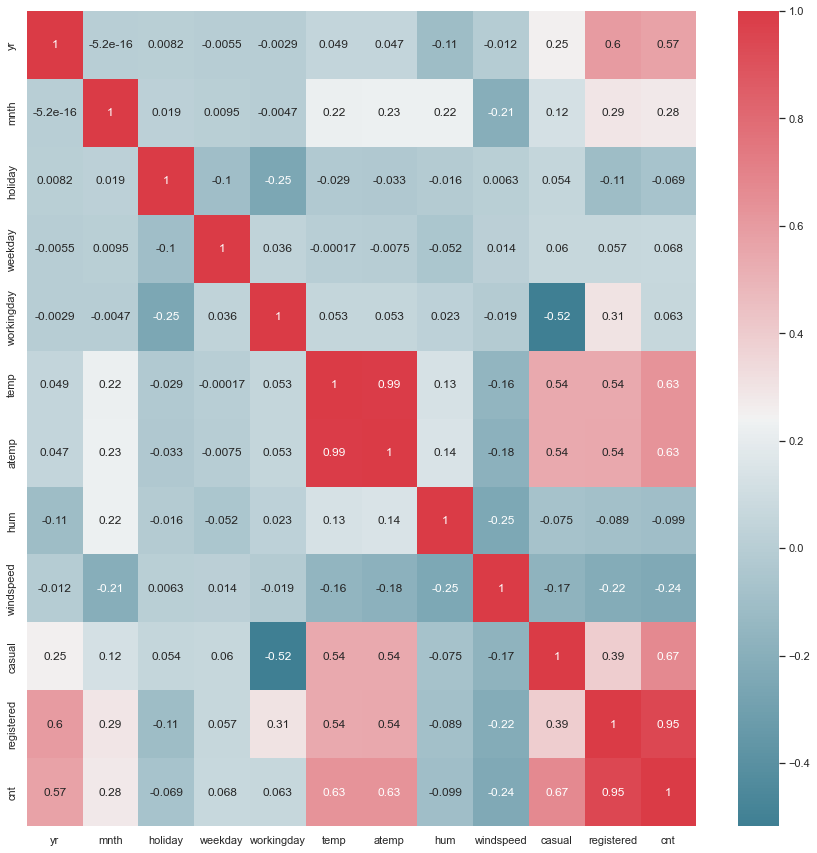

In [11]:
corr = df.corr()
sns.set(rc={'figure.figsize':(15,15)})
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True)

#### EDA observations
- Some variables are highly correlated. We will use VIF and p-value to reduce multicollinearity
- Variables casual and registered are a linear combination of target variable count, so we will not use them in any models
- Spring season and light weather seem to attract the least booking which could be due to the weather being good enough for walking to places.
- Holiday and weekday have negligible correlation to bookings but working day seems to have significant negative correlation in casual users. We can explore if this can be leveraged into a derived variable for the model.

### Data Preparation
- Convert categorical variables to dummy variables

In [12]:
# Replace season with dummies
df = pd.get_dummies(df, prefix='season', columns=['season'], drop_first=True)

In [13]:
# Replace weathersit with dummies
df = pd.get_dummies(df, prefix='weather', columns=['weathersit'], drop_first=True)

### Model Building

In [14]:
# Remove the target variable and variables highly correlated to target variable
# Remove the index columns and datetime variable
X = df[[x for x in df.columns if x not in ["casual", "registered", "cnt", "dteday", "instant"]]]
y = df[["cnt"]]

# Split the data into 80% training set, 20% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [15]:
# Scale the numerical variables using Min Max scaler
num_vars = ["temp", "atemp", "hum", "windspeed"]

scaler = MinMaxScaler()
scaler.fit(X_train[num_vars])
X_train[num_vars] = scaler.transform(X_train[num_vars])

# Here we dont fit scaler on X_test to avoid data leakage
X_test[num_vars] = scaler.transform(X_test[num_vars])

- Train a model with all variables to find p-values of predictor variables

In [16]:
# Train a OLS model using statsmodel api
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train.values, X_train).fit()

In [17]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     187.0
Date:                Sat, 12 Mar 2022   Prob (F-statistic):          3.19e-202
Time:                        01:15:32   Log-Likelihood:                -4750.7
No. Observations:                 584   AIC:                             9531.
Df Residuals:                     569   BIC:                             9597.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2470.6996    353.301      6.993      0.000    1776.766    3164.633
yr             1987.5289     70.394     28.234      0.000    1849.266    2125.792
mnth            -28.4987     19.629     -1.452      0.147     -67.053      10.056
holiday        -491.4001    204.320     -2.405      0.016    -892.714     -90.086
weekday          67.8582     17.361      3.909      0.000      33.758     101.958
workingday      134.0163     77.074      1.739      0.083     -17.368     285.401
temp           3291.8663   2077.237      1.585      0.114    -788.121    7371.854
atemp           882.7609   2197.222      0.402      0.688   -3432.895    5198.417
hum           -1029.3137    326.845     -3.149      0.002   -1671.283    -387.344
windspeed     -1124.7654    207.813     -5.412      0.000   -1532.940    -716.590
season_spring  -977.8442    199.404     -4.904      0.000   -1369.501    -586.187
season_summer   245.2219    128.266      1.912      0.056      -6.711     497.155
season_winter   802.7306    152.196      5.274      0.000     503.796    1101.665
weather_light -2079.9701    226.618     -9.178      0.000   -2525.080   -1634.861
weather_mist   -434.5669     92.163     -4.715      0.000    -615.587    -253.547
==============================================================================
Omnibus:                       75.776   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.865
Skew:                          -0.684   Prob(JB):                     7.20e-41
Kurtosis:                       5.393   Cond. No.                         706.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Find VIF for predictor variables

In [18]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by="VIF", ascending=False)
vif

Features     VIF
6            temp  185.80
7           atemp  181.75
0           const  104.26
10  season_spring    5.87
2            mnth    3.78
12  season_winter    3.68
11  season_summer    2.58
8             hum    1.92
14   weather_mist    1.60
13  weather_light    1.35
9       windspeed    1.26
3         holiday    1.10
5      workingday    1.09
1              yr    1.03
4         weekday    1.02

- Variables with high p-value
    - atemp
    - mnth
    - temp
    - workingday
    - season_summer
- Variables with high vif
    - temp
    - atemp
    - const
    
- We will remove the variables in following order:
1. atemp
2. Check again for changes in p-value and VIF

In [19]:
# Removing atemp
X_train = X_train.drop(["atemp"], axis=1)
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train.values, X_train).fit()

In [20]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     201.7
Date:                Sat, 12 Mar 2022   Prob (F-statistic):          2.39e-203
Time:                        01:15:32   Log-Likelihood:                -4750.8
No. Observations:                 584   AIC:                             9530.
Df Residuals:                     570   BIC:                             9591.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2472.0559    353.025      7.002      0.000    1778.667    3165.444
yr             1988.4764     70.302     28.285      0.000    1850.393    2126.560
mnth            -28.4691     19.615     -1.451      0.147     -66.995      10.056
holiday        -497.2219    203.656     -2.441      0.015    -897.230     -97.214
weekday          67.7440     17.346      3.905      0.000      33.674     101.814
workingday      134.9436     76.983      1.753      0.080     -16.261     286.148
temp           4118.4373    286.438     14.378      0.000    3555.835    4681.040
hum           -1012.7767    324.004     -3.126      0.002   -1649.165    -376.389
windspeed     -1145.7088    201.021     -5.699      0.000   -1540.541    -750.876
season_spring  -971.4653    198.624     -4.891      0.000   -1361.590    -581.340
season_summer   254.7904    125.943      2.023      0.044       7.421     502.159
season_winter   814.6962    149.144      5.462      0.000     521.758    1107.635
weather_light -2093.6190    223.892     -9.351      0.000   -2533.373   -1653.865
weather_mist   -438.2931     91.627     -4.783      0.000    -618.261    -258.325
==============================================================================
Omnibus:                       73.850   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              180.349
Skew:                          -0.667   Prob(JB):                     6.88e-40
Kurtosis:                       5.373   Cond. No.                         110.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
# VIF after removing atemp
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by="VIF", ascending=False)
vif

Features     VIF
0           const  104.25
9   season_spring    5.83
2            mnth    3.78
6            temp    3.54
11  season_winter    3.54
10  season_summer    2.49
7             hum    1.89
13   weather_mist    1.59
12  weather_light    1.32
8       windspeed    1.18
3         holiday    1.09
5      workingday    1.09
1              yr    1.03
4         weekday    1.02

In [22]:
# Removing season_summer
X_train = X_train.drop(["season_summer"], axis=1)
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train.values, X_train).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     217.0
Date:                Sat, 12 Mar 2022   Prob (F-statistic):          1.21e-203
Time:                        01:15:32   Log-Likelihood:                -4752.9
No. Observations:                 584   AIC:                             9532.
Df Residuals:                     571   BIC:                             9589.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2833.7407    305.231      9.284      0.000    2234.229    3433.253
yr             1992.8541     70.459     28.284      0.000    1854.463    2131.245
mnth            -46.6262     17.488     -2.666      0.008     -80.975     -12.278
holiday        -493.1426    204.197     -2.415      0.016    -894.211     -92.074
weekday          67.4761     17.392      3.880      0.000      33.315     101.637
workingday      138.6707     77.169      1.797      0.073     -12.899     290.240
temp           3869.3577    259.327     14.921      0.000    3360.007    4378.709
hum            -958.3463    323.758     -2.960      0.003   -1594.249    -322.444
windspeed     -1116.2909    201.037     -5.553      0.000   -1511.153    -721.429
season_spring -1259.3948    138.923     -9.065      0.000   -1532.257    -986.533
season_winter   709.3613    140.138      5.062      0.000     434.112     984.610
weather_light -2113.8326    224.274     -9.425      0.000   -2554.335   -1673.330
weather_mist   -435.7172     91.866     -4.743      0.000    -616.154    -255.280
==============================================================================
Omnibus:                       75.500   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              184.283
Skew:                          -0.681   Prob(JB):                     9.63e-41
Kurtosis:                       5.391   Cond. No.                         101.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
# VIF after removing season_summer
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by="VIF", ascending=False)
vif

Features    VIF
0           const  77.51
10  season_winter   3.11
2            mnth   2.99
6            temp   2.88
9   season_spring   2.84
7             hum   1.87
12   weather_mist   1.58
11  weather_light   1.32
8       windspeed   1.18
3         holiday   1.09
5      workingday   1.09
1              yr   1.03
4         weekday   1.02

### Residual Analysis
- Now that we are comfortable with the p-value and VIF of our predictor variables, we can perform residual analysis
- Residual analysis helps us validate that the assumptions of Linear regression are true for our model
- The residual plot should be close to a normal distribution

In [24]:
y_train_pred = model.predict(X_train)

In [25]:
res = y_train['cnt'] - y_train_pred

<AxesSubplot:ylabel='Density'>

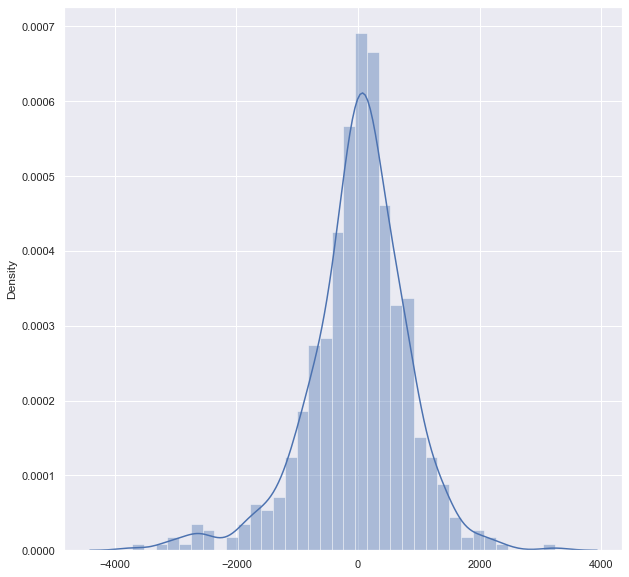

In [26]:
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(res)

### Predictions
- Now we will get the predictions from our trained model on our test set
- We will report the R2 score of the model

In [27]:
X_test = sm.add_constant(X_test)
y_pred = model.predict(X_test[X_train.columns])
r2_score(y_test, y_pred)

0.849641590555968

- The r2 score of our model is <b>0.8496</b>
- Plot predicted vs actual values of target variable to visualize how closely our model predicted

<AxesSubplot:xlabel='cnt'>

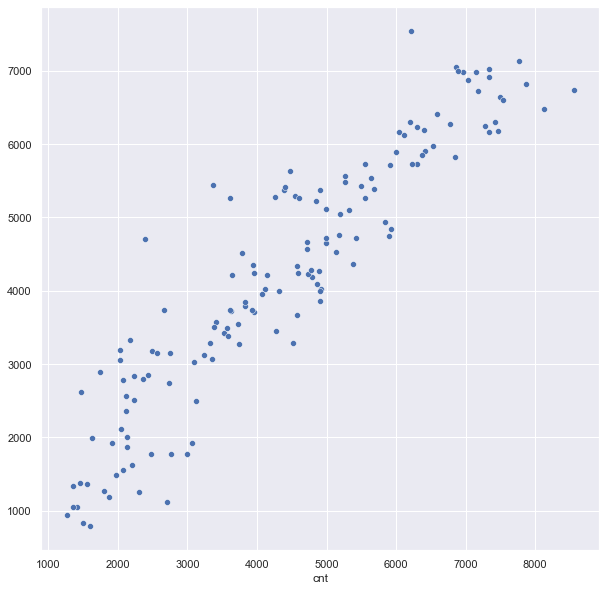

In [28]:
sns.scatterplot(y_test["cnt"], y_pred)

### RFE 
- This is an optional section
- Here we test out Recursive feature elimination for automated feature selection

In [29]:
# Create a linear regression model using sklearn
lm = LinearRegression()
lm.fit(X_train, y_train)
# Find out feature importance using RFE
rfe = RFE(lm, 10)
rfe = rfe.fit(X_train, y_train)

RFE feature importance:
- The features marked 'True' will be included in final model
- The ranking of features is provided next

In [30]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('const', False, 4),
 ('yr', True, 1),
 ('mnth', False, 3),
 ('holiday', True, 1),
 ('weekday', False, 2),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_spring', True, 1),
 ('season_winter', True, 1),
 ('weather_light', True, 1),
 ('weather_mist', True, 1)]

In [31]:
# Select only the variables selected by RFE
selected_cols = X_train.columns[rfe.support_]
X_train_rfe = X_train[selected_cols]

In [32]:
# Train statsmodel OLS for detailed summary
X_train_rfe = sm.add_constant(X_train_rfe)
model_rfe = sm.OLS(y_train.values, X_train_rfe).fit()
model_rfe.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.813
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     249.4
Date:                Sat, 12 Mar 2022   Prob (F-statistic):          2.34e-201
Time:                        01:15:32   Log-Likelihood:                -4764.0
No. Observations:                 584   AIC:                             9550.
Df Residuals:                     573   BIC:                             9598.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2981.0033    294.809     10.112      0.000    2401.964    3560.042
yr             1986.8943     71.668     27.724      0.000    1846.131    2127.658
holiday        -594.2557    206.586     -2.877      0.004   -1000.013    -188.498
workingday      152.7503     78.429      1.948      0.052      -1.293     306.794
temp           3680.6232    256.170     14.368      0.000    3177.477    4183.770
hum           -1121.7433    327.454     -3.426      0.001   -1764.900    -478.586
windspeed     -1125.9314    203.809     -5.524      0.000   -1526.236    -725.627
season_spring -1197.6920    137.588     -8.705      0.000   -1467.930    -927.454
season_winter   454.6180    108.413      4.193      0.000     241.683     667.553
weather_light -2068.8040    227.571     -9.091      0.000   -2515.779   -1621.829
weather_mist   -417.2167     93.375     -4.468      0.000    -600.615    -233.818
==============================================================================
Omnibus:                       67.673   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.031
Skew:                          -0.616   Prob(JB):                     2.40e-36
Kurtosis:                       5.286   Cond. No.                         21.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<AxesSubplot:ylabel='Density'>

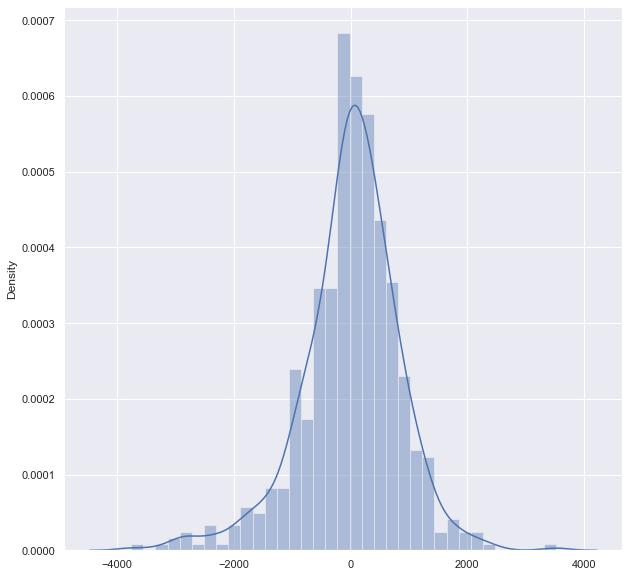

In [33]:
# Residual analysis
y_train_rfe_pred = model_rfe.predict(X_train_rfe)
res = y_train['cnt'] - y_train_rfe_pred
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(res)

In [34]:
# Test out of sample set
X_test = sm.add_constant(X_test)
y_pred = model_rfe.predict(X_test[X_train_rfe.columns])
r2_score(y_test, y_pred)

0.8501341305398435

- The r2 score of model with features selected by RFE is <b>0.850</b>

<AxesSubplot:xlabel='cnt'>

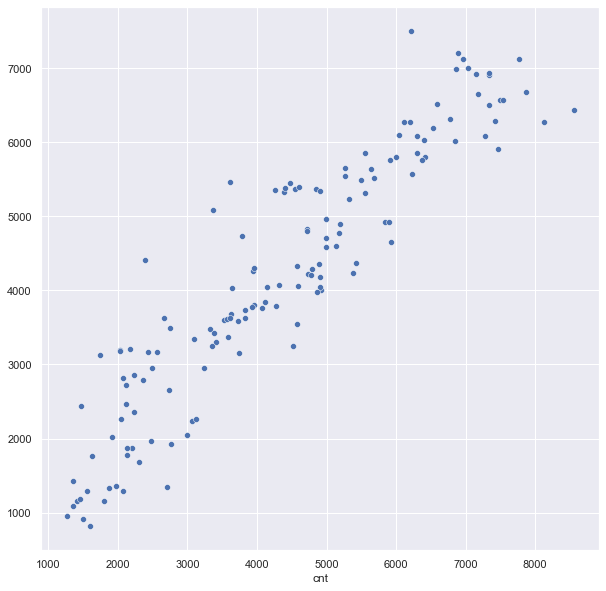

In [35]:
# Plot predicted vs true target variable
sns.scatterplot(y_test["cnt"], y_pred)